# Homework 3

HPC Applications

**Due May 6, no extensions!**

**collaboration statement:**

## Problem 1 (Dense linear algebra)

### a. (2 points)

This problem is about _cache blocking_ for dense matrix matrix multiplication.

Suppose we want to compute the dense matrix-matrix product, $C \gets C + AB$, where $A,B,C\in\mathbb{R}^{n\times n}$, but we are using a machine with a large, slow main memory and a small, fast cache that can fit $Z$ numbers at a time.

We will program this machine by explicitly loading _working sets_, submatrices of $A$, $B$, and $C$, from main memory into the cache and executing all of the fused multiply-add operations that have operands in the cache.
Each working set can be described by a triplet of three matrix slices, `((ai:aI, aj:aJ), (bi:bI, bj:bJ), (ci:cI, cj:cJ))`, which means that the working set is the submatrices `A[ai:aI, aj:aJ], B[bi:bI, bj:bJ], C[ci:cI, cj:cJ]`

Your job: write a function that, given a dimension $n$ and a cache size $Z$, returns a list of working sets that will complete the full matrix vector product in _as little memory movement as possible_.

To give you an example, here is a scheduler that tries to mimic the load order that comes from trying to load whole rows of $A$ and whole columns of $B$, which is the implicit work schedule when we use the basic triple-nested for loop, `for i = 1:n for j = 1:n for k = 1:n`.

In [45]:
function schedule_working_set_naive(n::Int64, Z::Int64)::Vector{NTuple{3,NTuple{2,UnitRange{Int64}}}}
    # Schedule the working sets as though we are following the I,J,K nested loop order,
    # this looks like a collection of inner products
    schedule = NTuple{3,NTuple{2,UnitRange{Int64}}}[]
    if (2*n + 1 >= Z)
        # we can't do more than one inner product
        blocksize = div(Z-1,2)
        blocksperrow = div(n-1,blocksize)+1
        for i = 1:n
            ir = i:i
            for j = 1:n
                jr = j:j
                for b = 1:blocksize:n
                    br = nothing
                    if b + blocksize - 1 <= n 
                        kr = b:(b+blocksize - 1)
                    else
                        kr = b:n
                    end
                    push!(schedule, ((ir,kr),(kr,jr),(ir,jr)))
                end
            end
        end
    else
        b = 1
        while ((2*(b+1)*n + (b+1)^2) <= Z)
            b += 1
        end
        for i = 1:b:n
            ir = nothing
            if i + b - 1 <= n
                ir = i:(i+b-1)
            else
                ir = i:n
            end
            for j = 1:b:n
                jr = nothing
                if j + b - 1 <= n
                    jr = j:(j+b-1)
                else
                    jr = j:n
                end
                kr = 1:n
                push!(schedule, ((ir,kr),(kr,jr),(ir,jr)))
            end
        end
    end
    return schedule
end

schedule_working_set_naive (generic function with 1 method)

I have written a `schedule_evaluator` that takes your schedule, makes sure it's valid (each work set fits in cache, all necessary fused-multiply adds are performed), and then measures the total memory moved into cache.

In [46]:
function schedule_evaluator(n, Z, schedule)
    aused = zeros(n,n)
    bused = zeros(n,n)
    cused = zeros(n,n)
    totalmoved = 0 
    for ((air,ajr),(bir,bjr),(cir,cjr)) in schedule
        if !isempty(setdiff(air,cir))
            println("Warning: loaded rows of A that cannot contribute to the loaded block of C")
        end
        if !isempty(setdiff(cir,air))
            println("Warning: loaded rows of C that cannot by updated by the loaded block of A")
        end
        ir = intersect(air,cir,1:n)
        if !isempty(setdiff(bjr,cjr))
            println("Warning: loaded columns of B that cannot contribute to the loaded block of C")
        end
        if !isempty(setdiff(cjr,bjr))
            println("Warning: loaded columns of C that cannot by updated by the loaded block of B")
        end
        jr = intersect(bjr,cjr,1:n)
        if !isempty(symdiff(ajr,bir))
            println("Warning: loaded columns of A and rows of B that cannot be multiplied together")
        end
        kr = intersect(ajr,bir,1:n)
        moved = length(air)*length(ajr) + length(bir)*length(bjr) + length(cir)*length(cjr)
        if moved > Z
            error("Tried to load more than will fit in the cache: $moved > $Z")
        end
        totalmoved += moved
        aused[ir,kr] .+= length(jr)
        bused[kr,jr] .+= length(ir)
        cused[ir,jr] .+= length(kr)
    end
    if any(aused .!= n) | any(bused .!= n) | any(cused .!= n)
        error("Not all fused multply adds were executed in the schedule")
    end
    return totalmoved
end     

schedule_evaluator (generic function with 1 method)

In [47]:
function schedule_evaluator(n, Z, schedule)
    aused = zeros(n,n)
    bused = zeros(n,n)
    cused = zeros(n,n)
    totalmoved = 0 
    for ((air,ajr),(bir,bjr),(cir,cjr)) in schedule
        if !isempty(setdiff(air,cir))
            println("Warning: loaded rows of A that cannot contribute to the loaded block of C")
        end
        if !isempty(setdiff(cir,air))
            println("Warning: loaded rows of C that cannot by updated by the loaded block of A")
        end
        ir = intersect(air,cir,1:n)
        if !isempty(setdiff(bjr,cjr))
            println("Warning: loaded columns of B that cannot contribute to the loaded block of C")
        end
        if !isempty(setdiff(cjr,bjr))
            println("Warning: loaded columns of C that cannot by updated by the loaded block of B")
        end
        jr = intersect(bjr,cjr,1:n)
        if !isempty(symdiff(ajr,bir))
            println("Warning: loaded columns of A and rows of B that cannot be multiplied together")
        end
        kr = intersect(ajr,bir,1:n)
        moved = length(air)*length(ajr) + length(bir)*length(bjr) + length(cir)*length(cjr)
        if moved > Z
           # println("$air, $ajr, $bir, $bjr, $cir, $cjr\n")
            error("Tried to load more than will fit in the cache: $moved > $Z")
        end
        totalmoved += moved
        aused[ir,kr] .+= length(jr)
        bused[kr,jr] .+= length(ir)
        cused[ir,jr] .+= length(kr)
    end
    if any(aused .!= n) | any(bused .!= n) | any(cused .!= n)
        error("Not all fused multply adds were executed in the schedule")
    end
    return totalmoved
end     

schedule_evaluator (generic function with 1 method)

Here is a plot of the total memory moved by the naive schedule for a fixed $n=32$ and a vary cache size $Z$.  Notice that there is a big drop in the memory movement once more than 4 rows/columns of a matrix can be loaded into cache.

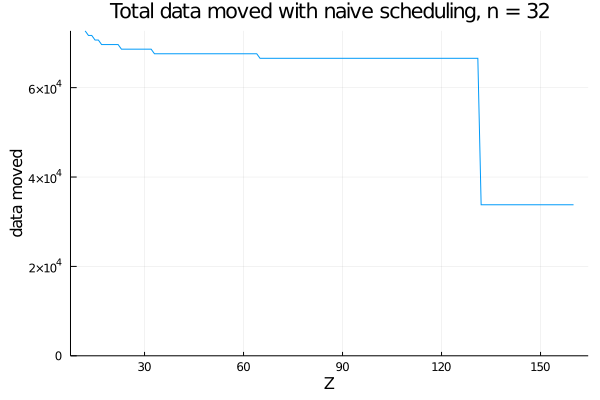

In [48]:
using Plots

n = 32

range = 12:(5*n)
totalmoved_naive = Vector{Int64}(undef, length(range))
for Z = range
    sched = schedule_working_set_naive(n, Z)
    totalmoved_naive[Z - 11] = schedule_evaluator(n, Z, sched)
end

plot(range, totalmoved_naive, legend=false)
plot!(title="Total data moved with naive scheduling, n = $n")
plot!(xlabel="Z", ylabel="data moved", ylim=(0,maximum(totalmoved_naive)))

Now it's your turn.  Write a schedule for loading working sets into cache that is more efficient than the naive approach.

(Hint: reread Prof. Vuduc's parallel matrix multiplication slides on Perusall.  Although we are scheduling one processor with a cache, cache scheduling has a lot in common with distributed memory algorithms, because you are trying to break up the work into pieces that can be done independently.  You should try to make each working set perform as many fused mutiply-adds as possible.)

In [49]:
#Setup similar to cannons alg. Instead of blocks though, create an array of ranges and shift those. 
#In each iteration, all blocks in the same position for each matrix need to loaded into the cache

function lshift(Array, row)
    #Get first elemnt
    fst = Array[row, 1]
    Array[row, 1:end-1] = Array[row, 2:end]
    Array[row, end] = fst
end

function upshift(Array, col)
   fst = Array[1, col]
    Array[1:end-1, col] = Array[2:end, col]
    Array[end, col] = fst
end



function schedule_working_set_efficient(n::Int64, Z::Int64)::Vector{NTuple{3,NTuple{2,UnitRange{Int64}}}}
    schedule = NTuple{3,NTuple{2,UnitRange{Int64}}}[]
    #Determin block size (this is the side_length of each Array that we can fit on the cache at once)
    b_size = floor(Int64, sqrt(Z / 3))
    range_array_size = (n % b_size == 0) ? div(n, b_size) : div(n, b_size) +1
    #Create an array of ranges, where each elemnt is a tuple of the ranges desscribing the "block"
    a_rngs = Array{NTuple{2,UnitRange{Int64}}, 2}(undef, range_array_size ,range_array_size)
    #Fill range array
    for i=1:b_size:n
        for j = 1:b_size:n
            row_ind = div(i, b_size) + 1
            col_ind = div(j, b_size) + 1
            row_end = (i+b_size-1 < n) ? i+b_size-1 : n
            col_end = (j+b_size-1 < n) ? j+b_size-1 : n
            a_rngs[row_ind, col_ind] = (i:row_end, j:col_end)
        end
    end
    b_rngs = copy(a_rngs)
    c_rngs = copy(a_rngs)
    
    #skew range arrays
    for i = 1:range_array_size
       for j = 1:i
           lshift(a_rngs, i)
           upshift(b_rngs, i)
        end
    end
    for i = 1:range_array_size
        for j = 1:range_array_size
            for k = 1:range_array_size
                push!(schedule, (a_rngs[j,k], b_rngs[j,k], c_rngs[j,k]))
            end
        end
        #Shift arrays after multiplying each block
        for j = 1:range_array_size
           lshift(a_rngs, j)
           upshift(b_rngs, j)
        end
    end
    return schedule
end

schedule_working_set_efficient (generic function with 1 method)

Your scheduler is evaluated against the naive solution in this plot.  There is also a line that models how much memory is moved by an efficient scheduler.  The model is not exact (your implementation can be above the modeled line), but your implementation should be much closer to the model than the naive implementation.

In [50]:
using Test

n = 32

range = 12:(5*n)
totalmoved_eff = Vector{Int64}(undef, length(range))
totalmoved_naive = Vector{Int64}(undef, length(range))
for Z = range
    sched = schedule_working_set_efficient(n, Z)
    totalmoved_eff[Z - 11] = schedule_evaluator(n, Z, sched)
    sched = schedule_working_set_naive(n, Z)
    totalmoved_naive[Z - 11] = schedule_evaluator(n, Z, sched)
end

plot(range, totalmoved_naive, label="naive")
plot!(range, totalmoved_eff, label="efficient")
plot!(title="Total data moved with both schedules, n = $n")
plot!(xlabel="Z", ylabel="data moved", ylim=(0,maximum(totalmoved_naive)))
rangea = collect(LinRange(12,5*n,100))
bound = n^3 * 3^1.5 ./ rangea.^0.5
plot!(rangea, bound, label="modeled efficient")
Test.@test true

Test Passed

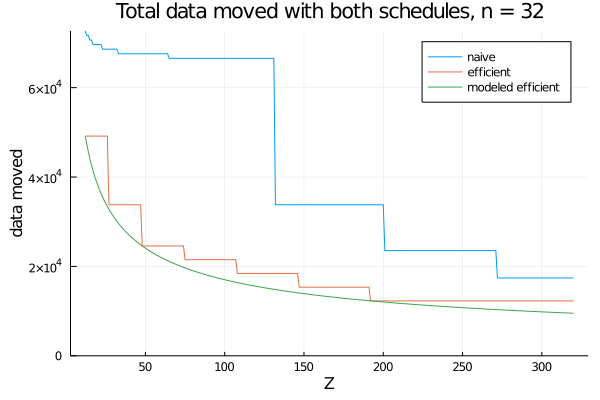

In [62]:
using Test

n = 32

range = 12:(10*n)
totalmoved_eff = Vector{Int64}(undef, length(range))
totalmoved_naive = Vector{Int64}(undef, length(range))
for Z = range
    sched = schedule_working_set_efficient(n, Z)
    totalmoved_eff[Z - 11] = schedule_evaluator(n, Z, sched)
    sched = schedule_working_set_naive(n, Z)
    totalmoved_naive[Z - 11] = schedule_evaluator(n, Z, sched)
end

plot(range, totalmoved_naive, label="naive")
plot!(range, totalmoved_eff, label="efficient")
plot!(title="Total data moved with both schedules, n = $n")
plot!(xlabel="Z", ylabel="data moved", ylim=(0,maximum(totalmoved_naive)))
rangea = collect(LinRange(12,10*n,100))
bound = n^3 * 3^1.5 ./ rangea.^0.5
plot!(rangea, bound, label="modeled efficient")
#Test.@test true

### b. (3 points)

The model of how much memory is moved in an efficient cache schedule above is $3^{3/2} n^3 / \sqrt{Z}$. Ignore the constant, but prove that this model is indeed a lower bound, that $\Omega(n^3 / \sqrt{Z})$ data must be loaded into the cache in order to complete the matrix-matrix multiplication.

(Hint: reread Prof. Vuduc's matrix multiplication slides on Perusall _again_.  The proof for the lower bound on memory movement in a parallel matrix-matrix multiplication is very similar to the proof you should give here).

Following Cannon's algorithm, each square block of C requires a similary sized square block from both $A$ and $B$ to update. Ultimatly, 3 blocks are brought into memory  bytes need to be loaded from memory into the cache at any point in the algorithm. Given that $Z$ is the maximum number of bytes we can bring into cach at once, the size of an individual block, $l$, satisfies $Z \geq 3l^2$, thus $l =O\left(\sqrt{\dfrac{Z}{3}}\right)$. To fully compute the matrix-matrix for a block in $C$, $\dfrac{n}{l}$ blocks from both $A$, $B$ and $C$ are moved into the cache. Each block has $l^2$ bytes, and $C$ is composed of $\left(\dfrac{n}{l}\right)^2$ blocks. Therefore $\dfrac{n^2}{l^2} \times 3\dfrac{n}{l} \times l^2 = \dfrac{3n^3}{l}$ bytes are moved into the cache for a matrix-matrix product operation. We showed before that $l =O\left(\sqrt{\dfrac{Z}{3}}\right)$. Substituting this into the equation for the number of bytes moved into the cache, we get that the lower bound on the number of bytes moved is $\Omega \left(\dfrac{3^{3/2}n^3}{\sqrt{Z}}\right)$ 

## Problem 2 (Sparse linear algebra & Graphs)

### a. (2 points)

Take this **compressed sparse row** representation of a matrix $A$ of size $n$ and multiply it against a dense vector $v$ (that is, compute a sparse matrix-vector product, or SpMV).

In [52]:
function spmv(m, n, rowoffsets, columns, avalues::Vector{T}, v::Vector{T})::Vector{T} where T
    ### m: number of rows
    ### n: number of columns (also length(v))
    ### rowoffsets: array of size m+1, rowoffset[i] is the start of the compressed row i in the avalues data
    ### columns: array (same size as avalues), the column for each entry of avalues
    ### avalues: the nonzeros of the matrix A, stored in compressed sparse row order
    ### v: the vector to multiply against
    ###
    ### output: return  A * x
    out = zeros(T,m)
    for i = 1:m
       rng = rowoffsets[i]:rowoffsets[i+1]-1
       out[i] = sum(avalues[rng] .* v[columns[rng]]) 
    end
    return out
end 

spmv (generic function with 1 method)

In [53]:
using SparseArrays

### Generate a random sparse matrix
m = 100
n = 138
v = rand(n)
### Create A'
Atranspose = sprand(n, m, 0.01)
out_yours = spmv(m, n, Atranspose.colptr, Atranspose.rowval, Atranspose.nzval, v)
out_native = Atranspose'*v

using LinearAlgebra

err = LinearAlgebra.norm(out_yours - out_native)
Test.@test err < 1.e-8 * LinearAlgebra.norm(out_native)

Test Passed

### b. (3 points)

In the lectures we discuss the sparse matrix / graph correspondence, and how computing the shortest path between two vertices in a graph can be computed using the [Tropical Semiring](https://en.wikipedia.org/wiki/Tropical_semiring).

Use your `spmv` to compute the **single source shortest path** from a given vertex $x$ in a graph with weighted edges (whose adjacency matrix is stored in compressed sparse row format).

In [54]:
import Base.+
import Base.*

struct TS # Tropical Semiring
    v::Float64
end

function +(a::TS, b::TS)::TS
    TS(min(a.v, b.v))
end

function *(a::TS, b::TS)::TS
    TS(a.v + b.v)
end

Base.zero(::Type{TS}) = TS(Inf64)

In [55]:
function single_source_shortest_path(n, rowoffsets, columns, edgeweights::Vector{TS}, x::Int64)::Vector{TS}
    # n: the number of vertices (== the number of rows and columns in the matrix)
    # rowoffsets: same as in spmv
    # columns: same as in spmv
    # edgeweights: like avalues in spmv, but representing the weights of the edges present in the graph
    # x: index of a vertex in the graph
    #
    # returns: a vector of the shortest distance from x to every other vertex in the graph
    # your code here
    minweights = zeros(TS, n)
    minweights[x] = TS(0)
    for i=1:n
        minweights += spmv(n,n, rowoffsets, columns, edgeweights, minweights)
    end
    return minweights
end

single_source_shortest_path (generic function with 1 method)

In [56]:
n = 100
G = sprand(n, n, 0.1)
x = rand(1:n)
nzval = map(TS,G.nzval)
d = single_source_shortest_path(n, G.colptr, G.rowval, nzval, x)



100-element Array{TS,1}:
 TS(0.8552189388072007)
 TS(0.5103259781482481)
 TS(0.41798269864440196)
 TS(0.6221833013195399)
 TS(0.4133130093459161)
 TS(0.15982275360684084)
 TS(0.11242640692388628)
 TS(0.7848289455664039)
 TS(0.4871701208020083)
 TS(0.20634735077830202)
 TS(0.41832586630684876)
 TS(0.6961856236923387)
 TS(0.4359702904389833)
 ⋮
 TS(0.5682672321131237)
 TS(0.7749346104775046)
 TS(0.32761696938588303)
 TS(0.4208915435442422)
 TS(0.4906752325408692)
 TS(0.6017598436233227)
 TS(0.6029672038971268)
 TS(0.42078704544832335)
 TS(0.6064233289716745)
 TS(0.5437500007383487)
 TS(0.8601107069116372)
 TS(0.587239053221787)

## Problem 3 (Fast Fourier Transform) (3 points)

In [57]:
using Pkg
Pkg.add("FFTW")
using FFTW

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


Here is the algorithm for multiplying to polynomials based on the FFT that is given in the slides.

In [58]:
function polynomial_multiply_fft(p, q)
    m = length(p) - 1
    n = length(q) - 1
    pext = zeros(m+n+1)
    qext = zeros(m+n+1)
    pext[1:length(p)] .= p
    qext[1:length(q)] .= q
    res = ifft(fft(pext) .* fft(qext))
    res = map(z -> z.re, res)
    return res
end

polynomial_multiply_fft (generic function with 1 method)

A matrix is called _Toeplitz_ if all the entries along
each diagonal of the matrix are equal. Thus, an $n\times n$
Toeplitz matrix has only $2n-1$ distinct elements. Toeplitz
matrices occur frequently in signal processing applications.
A $4\times 4$ Toeplitz matrix can be written as
$$\begin{bmatrix}
      t_3 & t_2 & t_1 & t_0\\
      t_4 & t_3 & t_2 & t_1\\
      t_5 & t_4 & t_3 & t_2\\
      t_6 & t_5 & t_4 & t_3\\
\end{bmatrix}.$$

A Toeplitz matrix is dense: if there is no other structure, a matrix vector product takes $O(n^2)$ operations.

Show that the product of an $n\times n$ Toeplitz matrix $T$ and an
$n$ element vector $[a_0\;\; a_1 \;\; a_2 \;\; \ldots \;\; a_{n-1}]$ can be computed using `polynomial_multiply_fft`, which is an $O(n \log n)$ algorithm.

In [59]:
polynomial_multiply_fft([1., 2., 3., 4.], [1., 2., 3., 4.])

7-element Array{Float64,1}:
  0.9999999999999979
  4.0
 10.0
 20.0
 25.0
 24.0
 16.0

In [60]:
function toeplitz_vector_product(t::Vector{T}, v::Vector{T})::Vector{T} where T
    # t: the coefficients of the Toeplitz matrix as they appear in the diagram
    # v: the vector
    #
    # return: the matrix vector product
    @assert length(t) == (2*length(v) - 1)
    # your code here
    product = polynomial_multiply_fft(t, v)
    mvp = product[length(v):length(t)]
    return mvp
    
    throw(MethodError)
end

toeplitz_vector_product (generic function with 1 method)

In [61]:
n = 10

function toeplitz_matrix(t)
    n = div(length(t) + 1, 2)
    A = zeros(n,n)
    for i = 1:(2*n-1)
        A[LinearAlgebra.diagind(A,n-i)] .= t[i]
    end
    return A
end

t = rand(2*n-1)
v = rand(n)

u_tvp = toeplitz_vector_product(t, v)

T = toeplitz_matrix(t)
u_mvp = T * v
diff = LinearAlgebra.norm(u_tvp - u_mvp)
Test.@test diff < 1.e-7 * LinearAlgebra.norm(u_mvp)

Test Passed